### Importando as Bibliotecas Necessárias

In [1]:
from IPython.display import display, Javascript, Image
from pyasn1_modules.rfc5208 import ValidationParms
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import html
import pandas as pd
import seaborn as sns
from google.colab import files
import os
from datetime import timedelta
from tensorflow.keras.utils import to_categorical

### Conectando-se à base de dados disponível no Google Drive

In [2]:
#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
patients_target_pain = os.listdir('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train')
basedir = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train/'
valdir = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Test/'

In [5]:
def prepara_dados():
  patients_data = []
  patients_target = []
  val_data = []
  val_target = []

  for i in range(len(patients_target_pain)):
    included_extensions = ['jpg','jpeg']
    imagens = [fn for fn in os.listdir(basedir+patients_target_pain[i]+'/')
                if any(fn.endswith(ext) for ext in included_extensions)]
    for j in range(len(imagens)):
      img = cv2.imread('{0}/{1}/{2}'.format(basedir,patients_target_pain[i],imagens[j]))
      img = cv2.resize(img,(96,96))
      patients_data.append(img)
      patients_target.append(i)

  for m in range(len(patients_target_pain)):
    included_extensions = ['jpg','jpeg']
    imagens = [fn for fn in os.listdir(valdir+patients_target_pain[m])
                if any(fn.endswith(ext) for ext in included_extensions)]
    for k in range(len(imagens)):
      img = cv2.imread('{0}/{1}/{2}'.format(valdir,patients_target_pain[m],imagens[k]))
      img = cv2.resize(img,(96,96))
      val_data.append(img)
      val_target.append(m)
    
  return patients_data, patients_target, val_data, val_target

patients_data, patients_target, val_data, val_target = prepara_dados()

O código acima prepara os dados de entrada do classificador. As variáveis `patients_data` e `val_data` armazenam numpy arrays representativos das imagens de treinamento e validação, enquanto as variáveis `patients_target` e `val_target` armazenam a classificação das imagens em 0, 1 ou 2, de acordo com o nível de esforço associado a cada imagem.

In [6]:
patients_data = np.array(patients_data)
patients_target = np.array(patients_target)
print(patients_data.shape)
print(patients_target.shape)

(1242, 96, 96, 3)
(1242,)


## Divisão do Dataset
Os dados são divididos em treinamento e validação, para o treino do classificador, enquanto uma parcela separada é armazenada nas váriaveis `X_test` e `y_test` para posterior avaliação da acurácia da rede. Esses últimos não são utilizados na etapa de _fit_ da rede, para que haja uma checagem de possibilidade de overfitting.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(patients_data, patients_target, test_size=0.20, random_state=42)
X_test, y_test = np.array(val_data),np.array(val_target)

In [8]:
print("Dimensão do tensor de dados de entrada de treinamento =", X_train.shape)
print("Dimensão do tensor de dados de entrada de validação =", X_val.shape)
print("Dimensão do tensor de dados de entrada de teste =", X_test.shape)
print("Dimensão do tensor de dados de saída de treinamento =", y_train.shape)
print("Dimensão do tensor de dados de saída de validação =", y_val.shape)
print("Dimensão do tensor de dados de saída de teste =", y_test.shape)

Dimensão do tensor de dados de entrada de treinamento = (993, 96, 96, 3)
Dimensão do tensor de dados de entrada de validação = (249, 96, 96, 3)
Dimensão do tensor de dados de entrada de teste = (257, 96, 96, 3)
Dimensão do tensor de dados de saída de treinamento = (993,)
Dimensão do tensor de dados de saída de validação = (249,)
Dimensão do tensor de dados de saída de teste = (257,)


In [9]:
# Guarda dimensão das imagens
image_dim = X_train.shape[1:4]
print("Dimensão das imagens de entrada=", image_dim)
# Transformação dos dados em números reais
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

Dimensão das imagens de entrada= (96, 96, 3)


In [10]:
# Transformação das classes de números reais para vetores
y_train_hot = to_categorical(y_train) 
y_val_hot = to_categorical(y_val) 
y_test_hot = to_categorical(y_test)

print('Dimensão dos dados de saída do conjunto de treinamento: ', y_train_hot.shape)
print('Dimensão dos dados de saída do conjunto de validação: ', y_val_hot.shape)
print('Dimensão dos dados de saída do conjunto de teste: ', y_test_hot.shape)

Dimensão dos dados de saída do conjunto de treinamento:  (993, 3)
Dimensão dos dados de saída do conjunto de validação:  (249, 3)
Dimensão dos dados de saída do conjunto de teste:  (257, 3)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

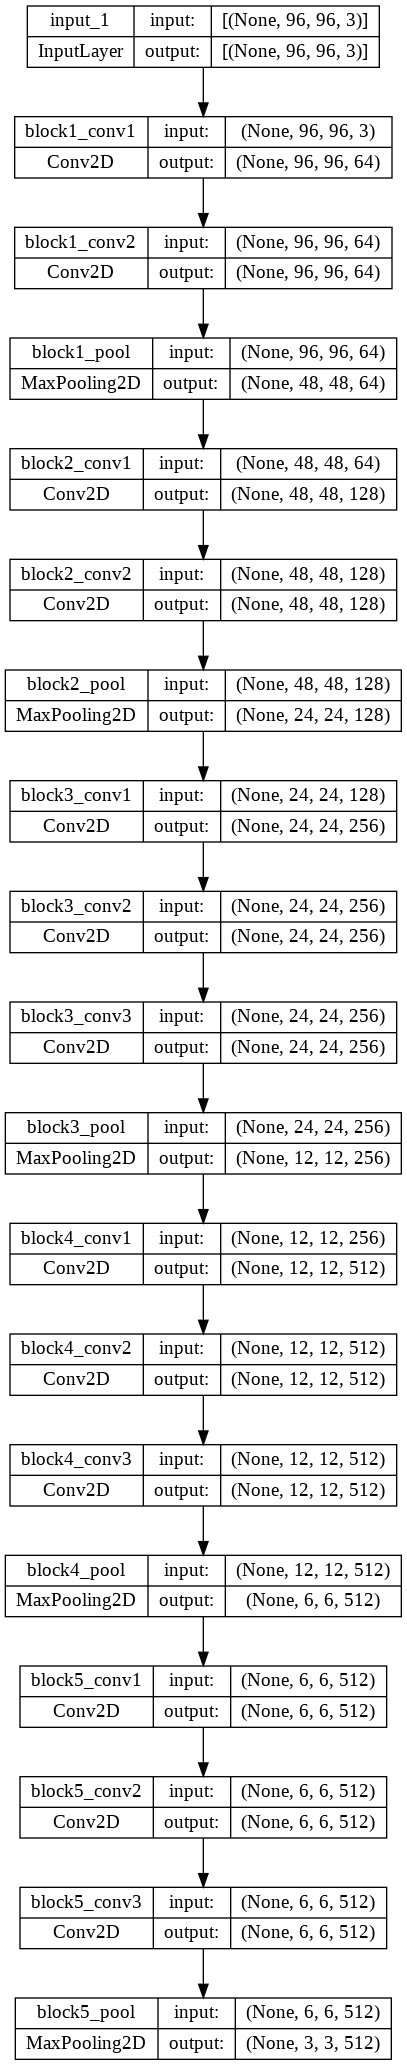

In [11]:
# Importa função para fazer gráfico de RNAs
from tensorflow.keras.utils import plot_model

# Carrega e salva a VGG16 excluindo suas camadas densas i
from tensorflow.keras.applications import VGG16
rna_base = VGG16(weights='imagenet', include_top=False, input_shape=image_dim)

# Mostra a arquitetura da VGG16
rna_base.summary()

# Cria um arquivo com o esquema da VGG16
plot_model(rna_base, to_file='VGG16.png', show_shapes=True)  

In [12]:
# Importa do Keras classes de modelos e de camadas
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
# Inicia RNA sequencial com a rna_base e adiciona as camadas de flattenning e densas
# Inclua seu código aqui
rna = models.Sequential()
rna.add(rna_base)
rna.add(layers.Flatten())
rna.add(layers.Dense(3, activation='softmax'))
# Visualização da arquitetura da rede
rna.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 3)                 13827     
                                                                 
Total params: 14,728,515
Trainable params: 14,728,515
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Número de parâmetros a serem treinados antes do congelamento
print('Número de parâmetros treináveis antes do congelamento =', len(rna.trainable_weights))
# Congelamento dos parâmetros da rna_base
rna_base.trainable = False
# Número de parâmetros a serem treinados após o congelamento
print('Número de parâmetros treináveis após o congelamento =', len(rna.trainable_weights))

Número de parâmetros treináveis antes do congelamento = 28
Número de parâmetros treináveis após o congelamento = 2


In [14]:
# Configuração do otimizador
from tensorflow.keras import optimizers
# Configuração do otimizador
adam = optimizers.Adam(learning_rate=0.001)
rna.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
# Treinamento da RNA
history = rna.fit(X_train, y_train_hot, epochs=10, verbose=1,
 validation_data=(X_val, y_val_hot))

Epoch 1/10
32/32 [==============================] - 124s 4s/step - loss: 0.7079 - accuracy: 0.7039 - val_loss: 0.5312 - val_accuracy: 0.7912
Epoch 2/10
32/32 [==============================] - 116s 4s/step - loss: 0.4493 - accuracy: 0.8167 - val_loss: 0.4406 - val_accuracy: 0.8594
Epoch 3/10
32/32 [==============================] - 118s 4s/step - loss: 0.3457 - accuracy: 0.8781 - val_loss: 0.3441 - val_accuracy: 0.9116
Epoch 4/10
32/32 [==============================] - 118s 4s/step - loss: 0.2785 - accuracy: 0.9154 - val_loss: 0.3041 - val_accuracy: 0.9237
Epoch 5/10
32/32 [==============================] - 117s 4s/step - loss: 0.2375 - accuracy: 0.9396 - val_loss: 0.2779 - val_accuracy: 0.9277
Epoch 6/10
32/32 [==============================] - 118s 4s/step - loss: 0.2120 - accuracy: 0.9376 - val_loss: 0.2669 - val_accuracy: 0.9317
Epoch 7/10
32/32 [==============================] - 118s 4s/step - loss: 0.1907 - accuracy: 0.9476 - val_loss: 0.2574 - val_accuracy: 0.9277
Epoch 8/10
32

In [15]:
# Define função para fazer os gráficos do treinamento
def plot_results_train(history):
    # Salva treinamento na variável history para visualização
    history_dict = history.history

    # Salva custos, métricas e epocas em vetores 
    custo = history_dict['loss']
    acc = history_dict['accuracy']
    val_custo = history_dict['val_loss']
    val_acc = history_dict['val_accuracy']

    # Cria vetor de épocas
    epocas = range(1, len(custo) + 1)

    # Gráfico dos valores de custo
    plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
    plt.plot(epocas, val_custo, 'ro', label='Custo - validação')
    plt.title('Valor da função de custo – treinamento e validação')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    plt.savefig('custo_pre.png')
    plt.show()
    

    # Gráfico dos valores da métrica
    plt.plot(epocas, acc, 'bo', label='exatidao- treinamento')
    plt.plot(epocas, val_acc, 'ro', label='exatidao - validação')
    plt.title('Valor da métrica – treinamento e validação')
    plt.xlabel('Épocas')
    plt.ylabel('Exatidao')
    plt.legend()
    plt.savefig('exatidao_pre.png')
    plt.show()
    
# Realiza os gráficos chamando função plot_results_train

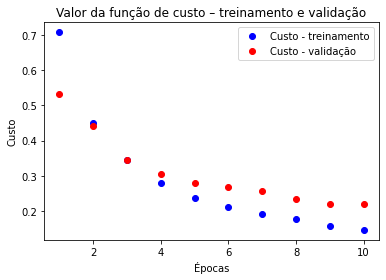

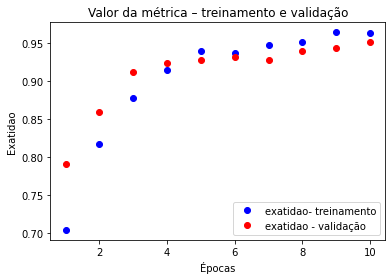

9/9 [==============================] - 24s 3s/step - loss: 0.1936 - accuracy: 0.9416


In [16]:
# Gráfico do processo de treinamento (use a função plot_results_train)
plot_results_train(history)
#Calculo do custo e exatidão para os dados de treinamento, validação e teste
custo_e_metricas_train = rna.evaluate(X_train, y_train_hot)
custo_e_metricas_val = rna.evaluate(X_val, y_val_hot)
custo_e_metricas_test = rna.evaluate(X_test, y_test_hot)

9/9 [==============================] - 27s 3s/step


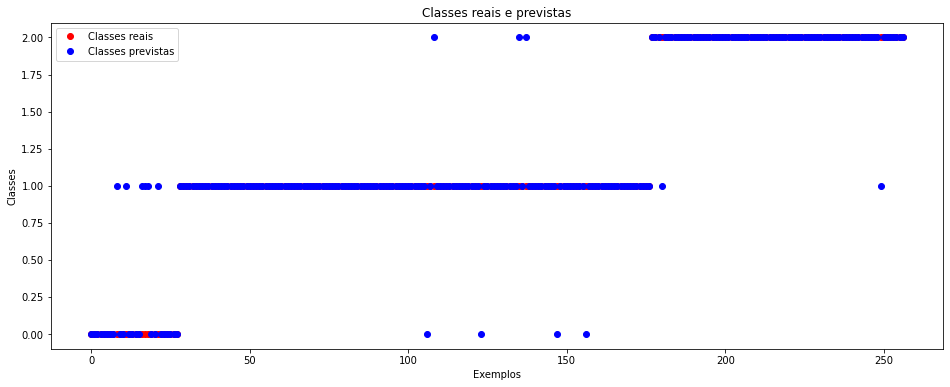

In [17]:
# Calculo das previsões da RNA
y_test_prev = rna.predict(X_test)
# Cálculo das classes previstas
classe = np.argmax(y_test_prev, axis=1)
# Gráfico das classes reais e previstas
# Fazer o gráfico das classes reais e previstas dos 150 primeiros exemplos de teste
plt.figure(figsize=(16, 6))
plt.plot(y_test[:], 'ro', label='Classes reais')
plt.plot(classe[:], 'bo', label='Classes previstas')
plt.title('Classes reais e previstas')
plt.xlabel('Exemplos')
plt.ylabel('Classes')
plt.legend()
plt.show()

In [18]:
# Descongela todas as camadas da rna_base
# Inclua seu código aqui
rna_base.trainable = True
set_trainable = False
# Percorre camadas da rna_base procurando pelo 5º bloco
# Inclua seu código aqui
for layer in rna_base.layers:
 if layer.name == 'block5_conv1':
  set_trainable = True

 if set_trainable:
  layer.trainable = True
 else:
  layer.trainable = False

print('Número de parâmetros treináveis após o descongelamento =', len(rna.trainable_weights))

Número de parâmetros treináveis após o descongelamento = 8


In [19]:
# Configuração do otimizador
# Inclua seu código aqui
adam = optimizers.Adam(lr=1e-05)
rna.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
# Treinamento da RNA
# Inclua seu código aqui
history2 = rna.fit(X_train, y_train_hot, epochs=10, validation_data=(X_val, y_val_hot), verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


32/32 [==============================] - 145s 5s/step - loss: 0.1165 - accuracy: 0.9658 - val_loss: 0.1749 - val_accuracy: 0.9558
Epoch 2/10
32/32 [==============================] - 145s 5s/step - loss: 0.0686 - accuracy: 0.9809 - val_loss: 0.1623 - val_accuracy: 0.9558
Epoch 3/10
32/32 [==============================] - 145s 5s/step - loss: 0.0551 - accuracy: 0.9889 - val_loss: 0.1522 - val_accuracy: 0.9639
Epoch 4/10
32/32 [==============================] - 146s 5s/step - loss: 0.0380 - accuracy: 0.9919 - val_loss: 0.1498 - val_accuracy: 0.9558
Epoch 5/10
32/32 [==============================] - 145s 5s/step - loss: 0.0601 - accuracy: 0.9778 - val_loss: 0.1669 - val_accuracy: 0.9518
Epoch 6/10
32/32 [==============================] - 143s 4s/step - loss: 0.0233 - accuracy: 0.9970 - val_loss: 0.1545 - val_accuracy: 0.9598
Epoch 7/10
32/32 [==============================] - 150s 5s/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.1478 - val_accuracy: 0.9558
Epoch 8/10
32/32 [======

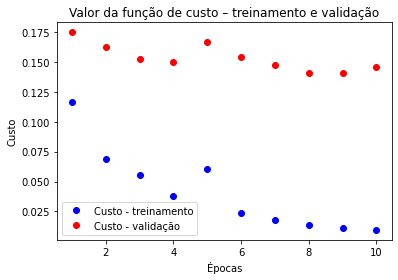

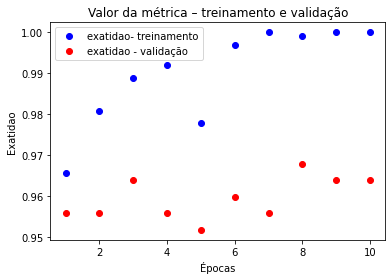

9/9 [==============================] - 24s 3s/step - loss: 0.2019 - accuracy: 0.9066


In [20]:
# Gráfico do processo de treinamento (use a função plot_results_train)
plot_results_train(history2)
#Calculo do custo e exatidão para os dados de treinamento, validação e teste
custo_e_metricas_train2 = rna.evaluate(X_train, y_train_hot)
custo_e_metricas_val2 = rna.evaluate(X_val, y_val_hot)
custo_e_metricas_test2 = rna.evaluate(X_test, y_test_hot)

9/9 [==============================] - 24s 3s/step


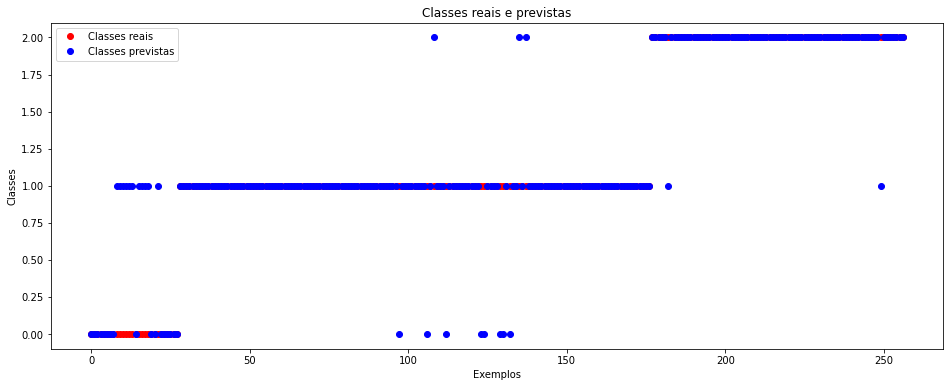

In [21]:
# Calculo das previsões da RNA
y_test_prev = rna.predict(X_test)
# Cálculo das classes previstas
classe = np.argmax(y_test_prev, axis=1)
# Gráfico das classes reais e previstas
# Fazer o gráfico das classes reais e previstas dos 150 primeiros exemplos de teste
plt.figure(figsize=(16, 6))
plt.plot(y_test[:], 'ro', label='Classes reais')
plt.plot(classe[:], 'bo', label='Classes previstas')
plt.title('Classes reais e previstas')
plt.xlabel('Exemplos')
plt.ylabel('Classes')
plt.legend()
plt.show()